# **Brain Tumor Detection**
### Author: Giuseppe Morgese
The objective of the project is to detect, outline and compute the area and perimeter of brain tumors in different MRI images.
It is necessary to point out that MRI images can be very different from each other depending on the type of MRI (T1,T2,FLAIR,...).
Thus the images have been selected from a dataset containing images acquired with the same technique. In the case of MRI images without tumors, a simple message “No tumor detected” will be displayed.

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Image loading
The image is loaded as a grayscale image since it's not that different from the original one and it's easier to work with

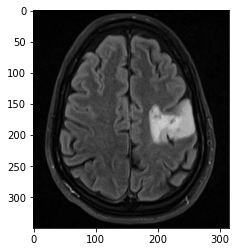

In [3]:
img = cv.imread("Y5.jpg", cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

X = img.shape[0] # image's height is used to scale the structuring elements utilized in morphology operations

copy = np.copy(img) # it's a good practice to work on a copy rather than on the original image itself

## Original intensity histogram

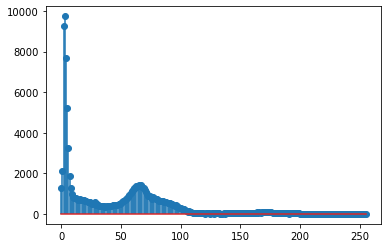

In [4]:
hist, bins = np.histogram(copy.flatten(),256,[0,256])
plt.stem(hist, use_line_collection=True)
plt.show()

## First enhancement
Adding an image to its blurred version improves the intensity contrast and regions' homogeneity

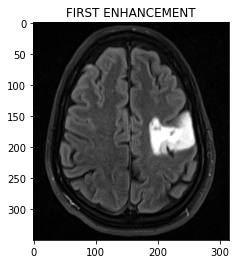

In [5]:
blur = cv.GaussianBlur(copy,(5,5),2)
enh = cv.add(copy,(cv.add(blur,-100))) # in order to avoid over-brightness of the image, blurred intensities are reduced
plt.imshow(enh, cmap='gray', vmin=0, vmax=255),plt.title("FIRST ENHANCEMENT")
plt.show()

## Intensity histogram after the first enhancement
The histogram below shows how the number of pixels at high intensities increases

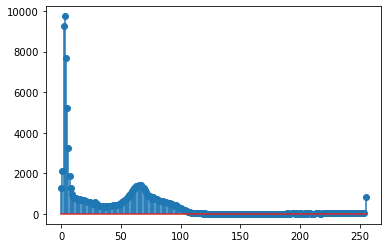

In [6]:
hist2, bins2 = np.histogram(enh.flatten(),256,[0,256])
plt.stem(hist2, use_line_collection=True)
plt.show()

## Denoising
A median filter is preferred given its edges-preservation properties

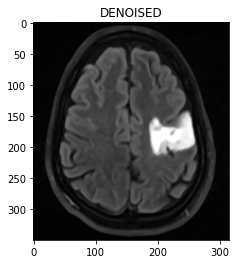

In [7]:
median = cv.medianBlur(enh,5)
plt.imshow(median, cmap='gray', vmin=0, vmax=255),plt.title("DENOISED")
plt.show()

## Morphological Gradient

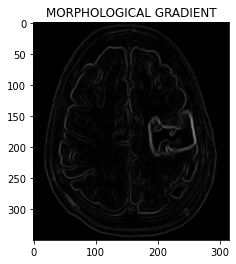

In [8]:
kernel = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
gradient = cv.morphologyEx(median, cv.MORPH_GRADIENT, kernel)
plt.imshow(gradient, cmap='gray', vmin=0, vmax=255),plt.title("MORPHOLOGICAL GRADIENT")
plt.show()

## Second enhancement
Adding the morphological gradient further improves intensity contrast of edges

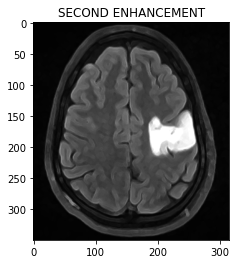

In [9]:
enh2 = cv.add(median,gradient)
plt.imshow(enh2, cmap='gray', vmin=0, vmax=255),plt.title("SECOND ENHANCEMENT")
plt.show()

## Intensity histogram after the second enhancement

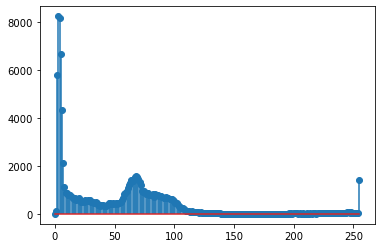

In [10]:
hist3, bins3 = np.histogram(enh2.flatten(),256,[0,256])
plt.stem(hist3, use_line_collection=True)
plt.show()

## First thresholding

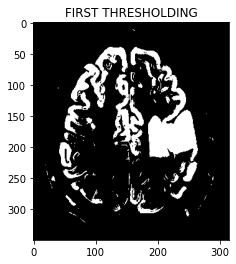

In [11]:
t = np.percentile(enh2,85) 
ret,th = cv.threshold(enh2, t, 255, cv.THRESH_BINARY)
plt.imshow(th, cmap='gray', vmin=0, vmax=255),plt.title("FIRST THRESHOLDING")
plt.show()

## Morphology operations

(<AxesSubplot:title={'center':'4. DILATION'}>,
 Text(0.5, 1.0, '4. DILATION'))

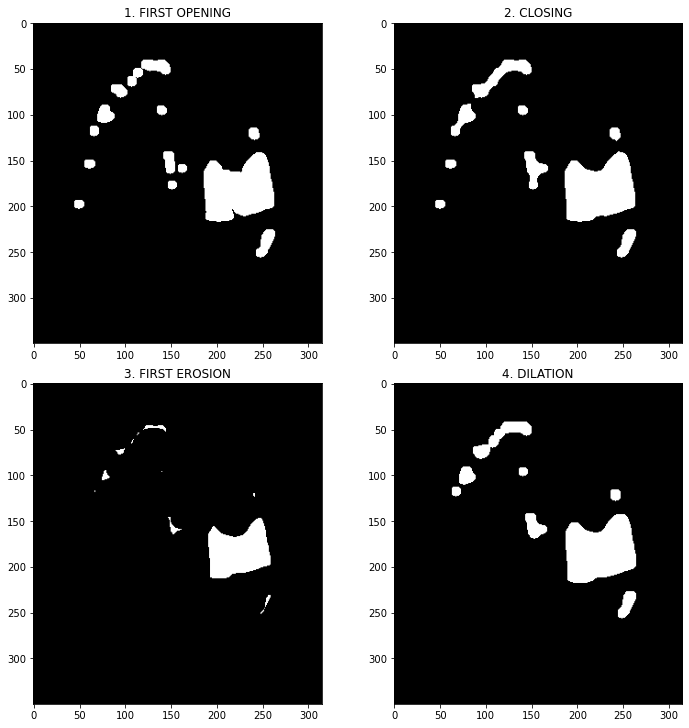

In [12]:
kernel_c = cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((5*X)/100),int((5*X)/100))) #
kernel_e = cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((3*X)/100),int((3*X)/100))) #
ker = cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((7*X)/100),int((7*X)/100)))

plt.figure(figsize=(10,10),constrained_layout = True)

opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel_e) # to eliminate small uninteresting structures
plt.subplot(221),plt.imshow(opening, cmap='gray', vmin=0, vmax=255),plt.title("1. FIRST OPENING")

closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel_c) # to merge the remaining structures that may have been divided
plt.subplot(222),plt.imshow(closing, cmap='gray', vmin=0, vmax=255),plt.title("2. CLOSING")

erosion = cv.erode(closing,kernel_e,iterations = 1)
plt.subplot(223),plt.imshow(erosion, cmap='gray', vmin=0, vmax=255),plt.title("3. FIRST EROSION")

dilation = cv.dilate(erosion,kernel_e,iterations = 1)
plt.subplot(224),plt.imshow(dilation, cmap='gray', vmin=0, vmax=255),plt.title("4. DILATION")

## Masking

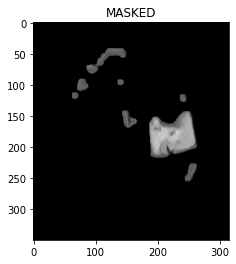

In [13]:
masked = cv.bitwise_and(copy, copy, mask=dilation)
plt.imshow(masked, cmap='gray', vmin=0, vmax=255),plt.title("MASKED")
plt.show()

## Second round of morphology operations

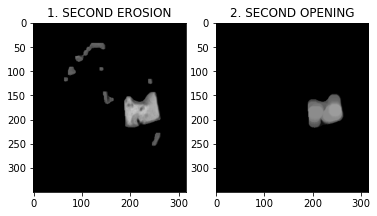

In [14]:
s_erosion = cv.erode(masked,kernel,iterations = 1)
plt.subplot(121),plt.imshow(s_erosion, cmap='gray', vmin=0, vmax=255),plt.title("1. SECOND EROSION")

final = cv.morphologyEx(s_erosion, cv.MORPH_OPEN, ker)
plt.subplot(122),plt.imshow(final, cmap='gray', vmin=0, vmax=255),plt.title("2. SECOND OPENING")
plt.show()

## Third enhancement

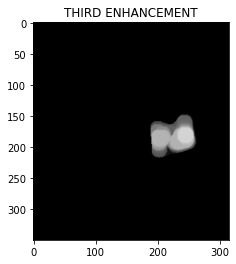

In [15]:
blur3 = cv.GaussianBlur(final,(3,3),0)
enh3 = cv.add(final,(cv.add(blur3,-100)))
plt.imshow(enh3, cmap='gray', vmin=0, vmax=255),plt.title("THIRD ENHANCEMENT")
plt.show()

## Second thresholding

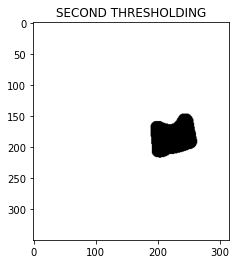

In [16]:
upper = np.percentile(enh3,92)
res = cv.inRange(enh3, 0, upper)
plt.imshow(res, cmap='gray', vmin=0, vmax=255),plt.title("SECOND THRESHOLDING")
plt.show()

## Final morphology step

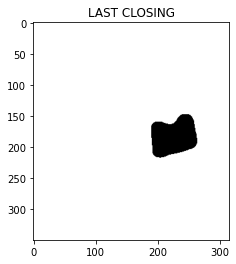

In [17]:
fin = cv.morphologyEx(res, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE,(int((7*X)/100),int((7*X)/100))))
plt.imshow(fin, cmap='gray', vmin=0, vmax=255),plt.title("LAST CLOSING")
plt.show()

## Contouring
In order to manage the contour found at the outer borders of the entire image, an if structure has been utilized.
The outer contour is the result of morphology and masking operations performed on the image.
Lastly the area and perimeter of the tumor is computed if detected.

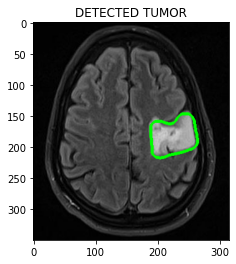

Area: 3934 px
Perimeter: 260 px


In [18]:
copy_rgb = cv.cvtColor(copy,cv.COLOR_BGR2RGB) # necessary step in order to print out the original image colors correctly

contours, hierarchy = cv.findContours(fin, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

if len(contours) > 1:
    cnt = contours[1]
    if len(contours) > 2:
        cv.drawContours(copy_rgb, contours, 2, (0,255,0), 3)
        plt.imshow(copy_rgb),plt.title("DETECTED TUMOR")
        plt.show()
    else:
        cv.drawContours(copy_rgb, contours, 1, (0,255,0), 3)
        plt.imshow(copy_rgb),plt.title("DETECTED TUMOR")
        plt.show()
    
    area = int(cv.contourArea(cnt))
    perimeter = int(cv.arcLength(cnt,True))
    
    print("Area:",area,"px")
    print("Perimeter:",perimeter,"px")
else:
    print("No tumor detected")